# BLS MLflow Example Notebook 5- BERTopic & Unsupervised Learning

*Remy Stewart, BLS Civic Digital Fellow Summer 2022*


# 1.0 Introduction
This example notebook explores an uncommon yet promising use case for MLflow intergration regarding tracking the associated models, generated parameters, and visual artifacts within an unsupervised machine learning project. MLflow was originally designed for supervised learning applications given that supervised models are the most common to be deployed within production and therefore in most need of comprehensive MLOps platform support. However, the flexibility of MLflow's Python API allows its methods to be easily customized to support unsupervised learning. Mlflow can in particular assist with ongoing challenges regarding how to interpret unsupervised results, both towards understanding whether generated values are rigorous and relevant as well as how changes in model parameters lead to different outcomes. 


## 1.1 Data & Model Goals
We will draw upon the public ONET occupational tasks data set once more within this unsupervised example notebook. Our goal is to fit unsupervised topic models on the work task text descriptions. We'll explore the state-of-the-art topic model framework of BERTopic, which as the name implies draws from BERT-based transformer architectures to create contextually-informed word embeddings to identify topics within text. 

BERTopic is an ideal choice for our unsupervised text analysis since it employs the linguistic pre-training of BERT to generate what are comparatively more cohesive topics in contrast to alternatives such as Latent Dirilecht Allocation (LDA). It's also a great method for us to explore towards our goal of understanding how MLflow can support all stages of unsupervised learning since BERTopic draws from multiple other unsupervised techniques- creating word embeddings, performing dimensionality reduction, and finding conceptual clusters- to identify its final topics. While BERTopic can easily implement all three stages of its unsupervised multi-model workflow in one API method call, we'll instead explore how we can understand and track each of these steps separately within MLflow.

# 2.0 Set-Up

Let's start by loading in our necessary libraries, which vary considerably than what we used within our previous example notebooks. All of the new libraries are included within the bls-mlflow conda environment within this repository, but the `pip install` call is specified below if needed for other Python environments. 

In [ ]:
#!pip install BERTopic sentence_transformers umap-learn hdbscan

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from tqdm.auto import tqdm
import tempfile
import os
import pickle
sns.set()

# Unsupervised libraries
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import hdbscan

# MLflow libraries
import mlflow
from mlflow.tracking import MlflowClient

We'll then connect to the remote MLflow server, create a new experiment for our unsupervised workflow, and initialize our current model run. 

In [ ]:
mlflow.set_tracking_uri("http://<Remote IP>:<Port>")
mlflow.get_tracking_uri()

In [ ]:
mlflow.set_experiment('bertopic-experiment')

In [ ]:
run = mlflow.start_run(run_name="bertopic_test")
print(f"Started run {run.info.run_id}")

# 3.0 Unsupervised Methods Behind BERTopic

This section will explore the three separate unsupervised techniques that underlie BERTopic models in turn. Let's go ahead and load in the ONET data set. The only column we'll be using in our analysis is the 'Task' text that specifies the daily work activities associated within a given occupation.

In [6]:
onet_base = pd.read_parquet("../data/onet_task_gwa.pqt")
onet_base.reset_index(inplace=True, drop=True)
onet_base['Task']

0        Review and analyze legislation, laws, or publi...
1        Review and analyze legislation, laws, or publi...
2        Direct or coordinate an organization's financi...
3        Confer with board members, organization offici...
4        Analyze operations to evaluate performance of ...
                               ...                        
19985    Unload cars containing liquids by connecting h...
19986    Copy and attach load specifications to loaded ...
19987    Start pumps and adjust valves or cables to reg...
19988    Perform general warehouse activities, such as ...
19989    Perform general warehouse activities, such as ...
Name: Task, Length: 19990, dtype: object

## 3.1 Embeddings via Sentence Transformers 

The first unsupervised method that BERTopic employs is to create word embeddings of the input text data via sentence transformer models. Sentence transformers are pre-trained for semantic similarity tasks designed to identify how proximate entire documents are to each other. These models create sentence embeddings that encodes the similarity between complete task sentences themselves rather than the similarity of the individual word sub-tokens within the task description that is obtained through standard BERT embeddings. This allows us to understand how complete documents align with each other within the fitted embedded vector space that we'll draw upon to identify topic clusters.

The following `embed_sentences` function processes our work task text into sentence embeddings through sample batches of 32 records at a time. We'll use the `all-MiniLM-L6-v2` pre-trained sentence transformer model architecture that collapses sentences to 384-dimensional dense vector space through a distilled model that is computationally quicker than the base BERT sentence transformer, tracking the dimension size as a MLflow parameter as well. 

In [7]:
def embed_sentences(sentence_transformer, onet_base):
    sample_size = len(onet_base)
    batch_size = 32
    embeds = np.zeros((sample_size, sentence_transformer.get_sentence_embedding_dimension()))

    for i in tqdm(range(0, sample_size, batch_size)):
        i_end = min(i+batch_size, sample_size)
        batch = np.array(onet_base['Task'][i:i_end])
        batch_embed = sentence_transformer.encode(batch)
        embeds[i:i_end,:] = batch_embed
    
    mlflow.log_param("Sentence Transformer Embedding Dimensionality", len(embeds[0]))
    print("Number of fitted dimensions per ONET task: ", len(embeds[0]))
    
    return embeds

In [8]:
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

embeds = embed_sentences(sentence_transformer, onet_base)

  0%|          | 0/625 [00:00<?, ?it/s]

Number of fitted dimensions per ONET task:  384


## 3.2 Dimensionality Reduction via UMAP

It's challenging to obtain interpretable topic clusters on high-dimensional vectors such as the 384 dimensions produced by our sentence transformer model. BERTopic therefore proceeds from encoding the text data into sentence embeddings by then performing dimensionality reduction via the Uniform Manifold Approximation and Production (UMAP) model. UMAP is supported by an underlying K-Nearest Neighbors algorithm that once optimally tuned will preserve both the local and global structure of embeddings by balancing both more proximate and more distant nearest neighbors data points respectively. It is therefore an ideal dimensionality reduction technique in contrast to PCA which tends to reduce dimensions at the loss of too much relevant information and the T-SNE clustering approach that favors preserving too many dimensions.

Deciding the number of dimensions to best serve our final topic model is a classically undefined process as seen throughout unsupervised learning methods. Despite the method's overall design strengths, UMAP does not support techniques found within PCA that assist with choosing the best-fitting values such as attempting to maximize the explained variance captured by the minimum amount of fitted components. There isn't any computable metrics for UMAP to compare differences in model performance by chosen hyperparameters such as the number of nearest neighbors by contrasting generated predictions to known label values. 

We'll therefore investigate how the discovered dimensions by the UMAP algorithm at different nearest neighbor thresholds identify dimensions visually. The [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/clustering.html) recommends that when using UMAP in preparation for clustering such as what we'll be employing for our topic model, we'll want to balance choosing a higher value of nearest neighbors to better fit global rathar than local variation for identifying clusters while also not choosing too high of a `n_neighbor` parameter that loses local information necessary to clearly differentiate between found topics. We'll therefore fit and plot nine potential nearest neighbor values along with a smaller than the model default `min_dist` value at 0 within the following `umap_search` function call, as no minimum distance regarding fitted embedding vectors promotes denser topical clusters. We'll use cosine similarity to compute the distance between our embeddings within our high-dimensional space and save our generated visualization as a MLflow artifact.

  0%|          | 0/9 [00:00<?, ?it/s]

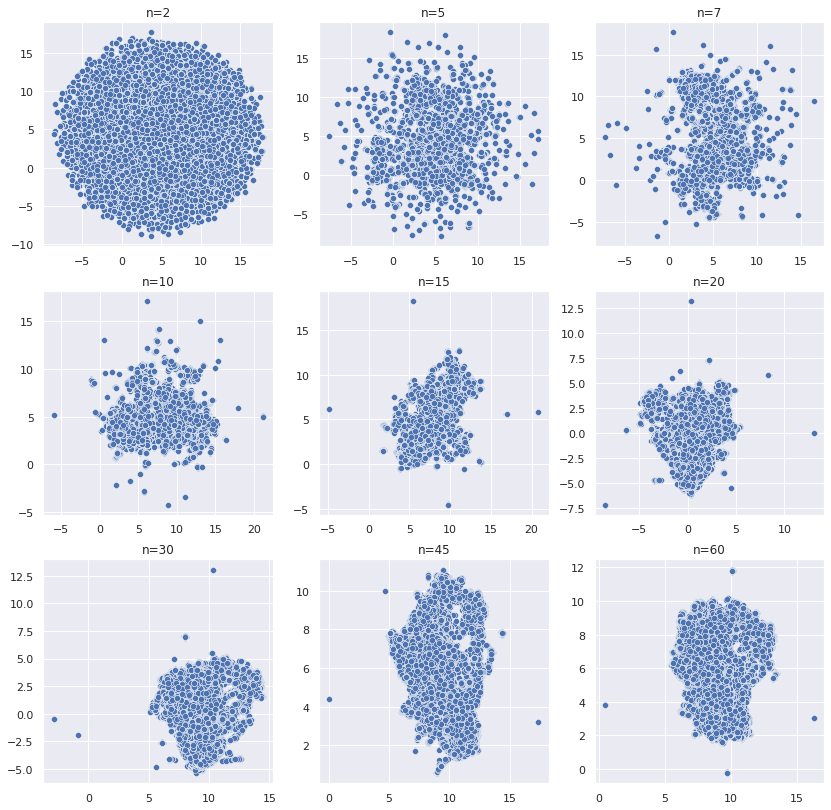

In [9]:
def umap_search(embeds): 
    fig, ax = plt.subplots(3, 3, figsize=(14, 14))
    n_neighbor_vals = [2, 5, 7, 10, 15, 20, 30, 45, 60]
    i, j = 0, 0
    for n_neighbors in tqdm(n_neighbor_vals):
        dim_reduce = UMAP(n_neighbors=n_neighbors, min_dist=0, metric='cosine', random_state=607)
        umap_val = dim_reduce.fit_transform(embeds)
        sns.scatterplot(x=umap_val[:,0], y=umap_val[:,1], ax=ax[j, i])
        ax[j, i].set_title(f'n={n_neighbors}')
        if i < 2: i += 1
        else: i = 0; j += 1

    tempdir = tempfile.mkdtemp()        
    umap_fig_path = os.path.join(tempdir, 'umap_fig.png')
    fig.savefig(umap_fig_path)
    mlflow.log_artifact(umap_fig_path)
    
umap_search(embeds)

It's common to see similar cluster visualizations like the one above used on data sets with pre-identified labels represented by different colors to understand how the fitted UMAP dimensions map to different classes. We don't have previously designated labels given that our identified topics will serve as labels inductively found via unsupervised learning which makes the above visualization more challenging to intepret. 

However, we can see that both the highest and lowest values for the number of nearest neighbors do not seem to change the dimension projections much beyond a large agglomeration of dimensions. The dimension space appears to stabilize at around 10 nearest neighbors, which suggests that 10 is an optimal value to move forward with for reducing our dimensions from the original 384 contained within our sentence transformer task embeddings.

We'll therefore want to establish our identified UMAP model set to 10 nearest neighbors, fit the the embeddings to this specified UMAP model to draw from in the next step of our unsupervised workflow, and then save the UMAP model as a MLflow artifact.

In [10]:
final_umap = UMAP(n_neighbors=10, min_dist=0.0, metric='cosine', random_state=607)
fitted_umap = final_umap.fit_transform(embeds)

tempdir = tempfile.mkdtemp()        
umap_pickled = os.path.join(tempdir, "umap.pkl")
pickle.dump(final_umap, open(umap_pickled, 'wb'))    
mlflow.log_artifact(umap_pickled)

## 3.3 Clustering via HDBSCAN

Following its use of UMAP for sentence embedding dimensionality reduction, BERTopic then creates hierarchial clusters of the embedding vectors via the HDBSCAN (Hierarchial Density-Based Spatial Clustering of Applications with Noise) algorith. HDBSCAN aims to cluster sentence embedding by identifying higher-density regions within embedding space contrasted to sparser, noisy areas by measuring the core distance between points to compute their proximity to each other. It's a clustering technique that's particularly effective at identifying unorthodoxly shaped clusters and correctly flagging outliers that would be likely to bias the results of other clustering algorithms.

The base DBSCAN clustering model sets one threshold value known as *episilon* to measure distance between potential core points to cluster by. HDBSCAN instead iterates through multiple thresholds that provides comparisons of clusters over various densities and is therefore more robust overall in its findings contrasted to a single episilon hyperparameter value within the original DBSCAN framework. This approach builds a hierarchy of clustered components based on whether clusters merge together at lower density values that accomodates greater distances between cluster points

Let's conduct a similar visual-based hyperparameter search as what we used for the UMAP model with the following `hdbscan_search` function, given that HDBSCAN also does not have built-in performance metrics to compare optimal hyperparameter values with. 

The most influential tunable hyperparameter within HDBSCAN is `min_cluster_size` indicating how many in distance threshold range points are required to identify an eligible cluster. We'll generally want to have larger cluster sizes to prevent too noisy of a cluster space from being created and therefore skew our nine-value cluster size search space towards larger values. We use `euclidean` distance as our metric to compute point proximity while the `prediction_data` parameters preserves the generated cluster for later use within our BERTopic model. 

  0%|          | 0/9 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

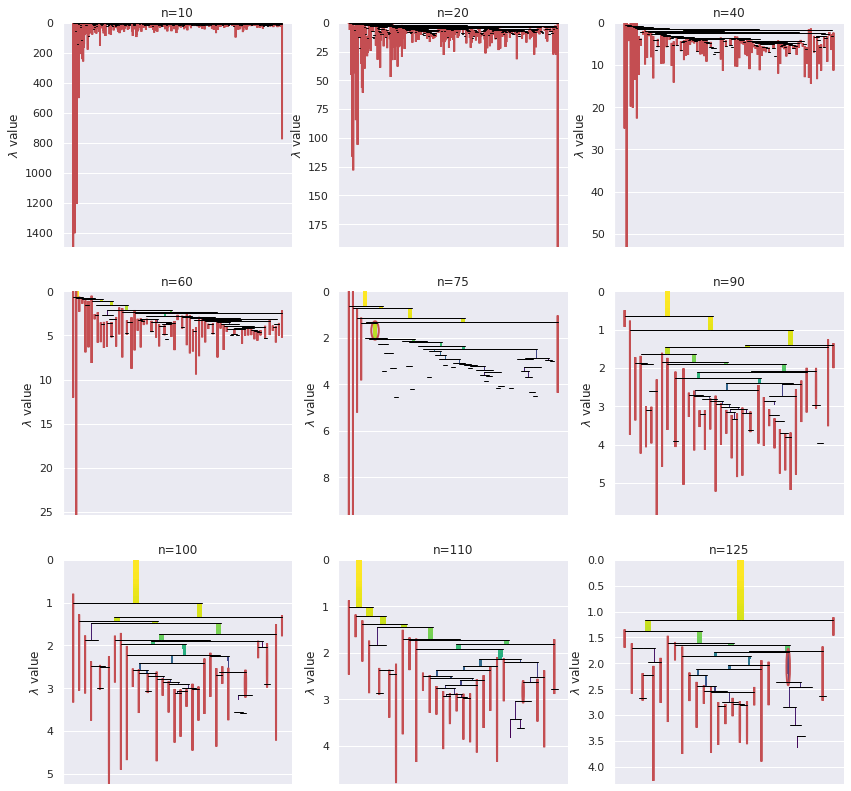

In [11]:
def hdbscan_search(fitted_umap): 
    fig, ax = plt.subplots(3, 3, figsize=(14, 14))
    cluster_sizes = [10, 20, 40, 60, 75, 90, 100, 110, 125]
    i, j = 0, 0
    for sizes in tqdm(cluster_sizes):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=sizes, metric='euclidean', prediction_data=True)
        fitted_clusters = clusterer.fit(fitted_umap)
        fitted_clusters.condensed_tree_.plot(select_clusters=True, axis=ax[j, i], colorbar=False)
        ax[j, i].set_title(f'n={sizes}')
        if i < 2: i += 1
        else: i = 0; j += 1
        
    tempdir = tempfile.mkdtemp()        
    hdbscan_fig_path = os.path.join(tempdir, 'hdbscan_fig.png')
    fig.savefig(hdbscan_fig_path)
    mlflow.log_artifact(hdbscan_fig_path)

hdbscan_search(fitted_umap)

The generated visualization by `hdbscan_search` is more readily interpretable then our comparable figures for UMAP dimensionality reduction. Each of the verticle lines within the figure represent a level of the found cluster hierarchy, with lower lines capturing deeper cluster values within the created tree of clusters. Lines highlighted in red by the model represent found clusters that meet our specified thresholds regarding `min_cluster_size` and `min_samples`. 

We can see that the generated HDBSCAN models across the `min_cluster_size` parameters end up prioritizing too many clusters at the earlier levels while focusing on smaller cluster subsets exclusively within the leaf nodes at the higher levels. It seems that a cluster parameter at 60 is around where the model is identifying a range of clusters fit within the hierarchy before loosing the range of clusters found at the higher `min_cluster_size` levels. 

We'll therefore want to create an object that stores the HDBSCAN model with this identified minimum cluster size to be used shortly within our BERTopic model. We'll go ahead and save the HDBSCAN model as a pickle file within MLflow as well. 

In [12]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=60, metric='euclidean', prediction_data=True)

hdbscan_pickled = os.path.join(tempdir, "hdbscan.pkl")
pickle.dump(clusterer, open(hdbscan_pickled, 'wb'))    
mlflow.log_artifact(hdbscan_pickled)

# 4.0 Initializing the BERTopic Model 

Following transformating the ONET task text into sentence-level word embeddings, collapsing the embeddings into the 50 dimensions that best characterized the found variability by the UMAP model, and identifying dimensional clusters via HDBSCAN, BERTopic concludes its comprehensive multi-step unsupervised analysis by extracting the words that best characterized each discovered topical cluster. This extraction is achieved by using either a `CountVectorizer` or `TfidfVectorizer` model from Scikit-learn. We'll use `TfidfVectorizer` for our model since TF-IDF will place more importance on rare words that are strongly associated with specific topics which will be helpful towards ensuring minimal word and conceptual overlap between the found topics. 

We pass in our previously created UMAP and HDBSCAN models along with our pre-trained sentence transformer directly as BERTopic parameters within the following `fit_BERTopic` function. Setting the `nr_topics` parameter to 50 ensures that BERTopic aimes to fit at most around 50 topics for our data. `top_n_words` is used to indicate that we want each topic to be established with 5 keywords, while `language` specifies that we're only processing text in English. Setting `verbosity=True` signals BERTopic to print out the underlying unsupervised methods steps while fitting the model. This can be particularly helpful for keeping track of BERTopic's processing of a large corpus and/or a high number of topics where the model can take some time to converge. 

We then fit and transform our ONET task data text simulatenously with our configured BERTopic model. The fitted data's `topics` object output lists which topic each task record was assigned to, while `probabilities` lists the likelihood of a task record being assigned to each of the fitted topics. ### CHECK THIS!!!!!

Logging BERTopic's parameters into MLflow automatically collects the parameters of the underlying UMAP and DBSCAN models. Saving the model as a MLflow artifact combines both the fitted topic model itself and the pretrained sentence transformers used to create the sentence embeddings into one file. The final UMAP, HDBSCAN, and TF-IDF vectorizer models are all packaged into the saved topic model as well. 

In [13]:
def fit_BERTopic(onet_base): 
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
    sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

    topic_model = BERTopic(
        umap_model=final_umap,
        hdbscan_model=clusterer,
        embedding_model=sentence_transformer,
        vectorizer_model=vectorizer,
        top_n_words=5,
        language='english',
        nr_topics=50,
        calculate_probabilities=True,
        verbose=True)
    
    topics, probabilities = topic_model.fit_transform(onet_base['Task'])
    
    topic_params = topic_model.get_params()
    mlflow.log_params(topic_params)
    
    bertopic_path = os.path.join(tempdir, 'topic_model.bin')
    topic_model.save(bertopic_path, save_embedding_model=True)
    mlflow.log_artifact(bertopic_path)
    
    return topics, probabilities, topic_model

topics, probabilities, topic_model = fit_BERTopic(onet_base)    

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2022-08-09 15:57:20,031 - BERTopic - Transformed documents to Embeddings
2022-08-09 15:57:37,135 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2022-08-09 15:57:41,660 - BERTopic - Clustered reduced embeddings
2022-08-09 15:57:51,599 - BERTopic - Reduced number of topics from 51 to 51


## 4.1 Tabular Topic Model Results

Now that we have a fitted BERTopic model on the ONET task data, let's start our exploration of the identified topics by first considering the results via summary Pandas tables. The following `topic_tables` function performs multiple DataFrame transformations to produce one table that focuses on the count of each fitted topic across the task records along with the top keywords for the topic. The function additionally generates a table that collects the top three most associated documents for each fitted topic. Both tables are then stored as HTML files within MLflow. 

In [14]:
def topic_tables(topic_model):
    # Topic overview table
    topic_table = topic_model.get_topic_info()
    mlflow.log_param('Number of Identified Topics', len(topic_table))
    
    del topic_table['Topic']
    topic_table = topic_table.iloc[1:]
    topic_table = topic_table.rename(columns={"Name":"Keywords"})
    topic_table.index.rename("Topic", inplace=True)
    
    # Saving topic table into MLflow
    topic_table_html = os.path.join(tempdir, "topic_table.html")
    topic_table.to_html(topic_table_html)
    mlflow.log_artifact(topic_table_html)
    
    # Top documents by topic table
    doc_list = []
    for indexes in range(len(topic_table)-1):
        strings = topic_model.get_representative_docs(topic=indexes)
        doc_list.append(strings[:3])
    doc_table = pd.DataFrame(doc_list, columns = ["Doc 1", "Doc 2", "Doc 3"])
    doc_table.index.rename("Topic", inplace=True)
    pd.set_option('display.max_colwidth', 500)
    
    # Saving topic table into MLflow
    doc_table_html = os.path.join(tempdir, "doc_table.html")
    doc_table.to_html(doc_table_html)
    mlflow.log_artifact(doc_table_html)

    return topic_table, doc_table

In [15]:
topic_table, doc_table = topic_tables(topic_model)
topic_table

,Count,Keywords
Topic,,
1,1444,0_patients_patient_treatment_medical
2,836,1_hand tools_hand_tools_using
3,764,2_records_data_reports_database
4,722,3_environmental_water_geographic_sustainability
5,542,4_malfunctions_test_inspect_equipment
6,492,5_students_teachers_instructional_teach
7,438,6_replace_repair_defective_hand tools
8,402,7_surfaces_smooth_molds_paint
9,402,8_train_hire_staff_employees


We can see from the above table the 51 topics discovered by our model, the wide range of topic frequency across the records, and the top key words for our diverse topics. From "patients" to "hand tools" to "environmental", this table clearly indicates that our model has identified a range of occupational task clusters that cover the host of economic sectors and industries featured within our ONET data.  

Let's consider the most associated documents per topic within the generated `doc_table` as well.

In [16]:
doc_table

,Doc 1,Doc 2,Doc 3
Topic,,,
0,Price and file prescriptions that have been filled.,Prescribe radionuclides and dosages to be administered to individual patients.,"Calculate equipment operating factors, such as radiation times, dosages, temperatures, gamma intensities, or pressures, using standard formulas and conversion tables."
1,"Lift, position, and secure machined parts on surface plates or worktables, using hoists, vises, v-blocks, or angle plates.","Set up, operate, or tend machines to saw, cut, shear, slit, punch, crimp, notch, bend, or straighten metal or plastic material.","Tend machines that twist together two or more strands of yarn or insert additional twists into single strands of yarn to increase strength, smoothness, or uniformity of yarn."
2,Report results of statistical analyses in peer-reviewed papers and technical manuals.,Combine secondary data sources with keyword research to more accurately profile and satisfy user intent.,"Record production and test data for each food product batch, such as the ingredients used, temperature, test results, and time cycle."
3,Direct aerial surveys of specified geographical areas.,"Create, prepare, or requisition graphic or narrative reports on land use data, including land area maps overlaid with geographic variables, such as population density.","Conduct, or oversee the conduct of, investigations on matters such as water storage, wastewater discharge, pollutants, permits, or other compliance and regulatory issues."
4,Test mechanical products and equipment after repair or assembly to ensure proper performance and compliance with manufacturers' specifications.,"Monitor automated press operation systems and respond to fault, error, or alert messages.","Monitor machine operations to determine whether adjustments are necessary, stopping machines when problems occur."
5,"Instruct students in the knowledge and skills required in a specific occupation or occupational field, using a systematic plan of lectures, discussions, audio-visual presentations, and laboratory, shop, and field studies.",Write instructional articles on designated subjects.,"Present information with a variety of instructional techniques or formats, such as role playing, simulations, team exercises, group discussions, videos, or lectures."
6,Repair or remove and replace system components.,Disassemble units to replace parts or to crate them for shipping.,"Replace parts, such as gears, magneto points, piston rings, or spark plugs, and reassemble engines."
7,"Apply primers or sealers to prepare new surfaces, such as bare wood or metal, for finish coats.","Mold or install ornamental plaster pieces, panels, or trim.","Mix catalysts into resins, and saturate cloth and mats with mixtures, using brushes."
8,Hire and terminate clerical and administrative personnel.,Manage projects or contribute to committee or team work.,"Appoint individuals to faculty positions, and evaluate their performance."


This table provides insights on a selection of influential documents for each topic, particularly regarding how the delineated tasks themselves can certainly vary from each other but often capture similar overarching themes and/or relevant keyrwords. For example, the three documents for Topic 0 focus on treatments, measuring radiation, and providing instructions, but they are connected in their use of language centering treatments, dosages, patients, and other words closely tied to healthcare occupations. 

## 4.2 Visual Topic Model Results

Topic models contain such a large degree of information and dimensions of interest that tabular representations of model insights can be a challenge to efficiently process. Visualizations are therefore a great method to support topic model interpretation and easily identify key finding takeaways. BERTopic supports a wide range of visualization methods to serve this exact purpose. All of the following methods produce dynamic Plotly visuals that can be saved as HTML files within MLflow and then directly interacted with within the remote tracking server.

### 4.2.1 Visualizing Topics 

Let's start by employing the `visualize_topics` method that displays topic location within the fitted embedding space mapped on axes generated via an underlying PCA conversation to contrast the two largest principle components of variation within the model. 

In [17]:
topic_viz = topic_model.visualize_topics()

topic_viz_path = os.path.join(tempdir, 'topic_viz.html')
topic_viz.write_html(topic_viz_path)
mlflow.log_artifact(topic_viz_path)

![topic_viz.png](../imgs/topic_viz.png)

This figure alludes to the distinct hierachial clusters among our topics. This is a screenshot of the original Plotly figure so that it renders correctly in Gitlab which does not support Javascript-based plots. The original figure itself is fully interactive within the run's MLflow artifact directory, however, so I'll focus on the key takeways from the live visualization. 

The largest cluster that's farthest to the left in the lower left quandrant gathers topics that highlight keywords such as "patients", "athletics", and "students", suggesting that these topics map closely to occupations that are people-facing such as healthcare professionals, athletes, and teachers. In contrast, the largest cluster in the bottom right quandrant aggregates topics that include keywords such as "valves", "hand tools", and "surfaces", implying that this topical cluster is characterized by occupations that are more affiliated with manual labor.  

### 4.2.2 Topic Hierarchy
`visualize_hierarchy` draws from the hierarchial cluster relationship featured with HDBSCAN to consider how found topics relate to each other based on common thematic ancestry. It creates a dendrogram that makes the split paths between the found topical clusters easily traceable. 

In [18]:
hierarchy = topic_model.visualize_hierarchy()

hier_viz_path = os.path.join(tempdir, 'hier_viz.html')
hierarchy.write_html(hier_viz_path)
mlflow.log_artifact(hier_viz_path)

![hier_viz.png](../imgs/hier_viz.png)

This visualization traces the relational paths between the topic divisions where topics that are closely connected to each other overall make intuitive sense. This is observable with the first two plotted topics of Topic 26 regarding trucks and tractors and Topic 23 regardind supplies and inventory that likely originate from a common ancenstry regarding occupations connecting to retail product distribution and supply chains. The next two following topics of 44 "sterilize_disinfect" and 42 "clean_clean work" seem to both descend from cleaning-based employment tasks. 

### 4.2.3 Topic Probability Distribution
`visualize_distribution` considers the topic probabilities of a single sample within our ONET task data set.

In [19]:
dist = topic_model.visualize_distribution(probabilities[5]) 

dist_viz_path = os.path.join(tempdir, 'dist_viz.html')
dist.write_html(dist_viz_path)
mlflow.log_artifact(dist_viz_path)

![dist_viz.png](../imgs/dist_viz.png)

We can see that Topic 24 is the model's highest prediction regarding topic membership for this task record with Topic 38 at a distant second place. Let's get a closer look at the top keywords affiliated with Topic 24 through the `get_topic` method:

In [19]:
topic_model.get_topic(24)

[('budget', 0.03502761932640465),
 ('financial', 0.03358735101679725),
 ('budgets', 0.03133684951306963),
 ('accounting', 0.02455773135447638),
 ('departments', 0.02161700761241612)]

This is clearly a topic focused on financial tasks and bureaucratic management. It would be helpful to examine the ONET task record text itself to better understand how the words used to describe the task influenced the resulting topic probability distribution. 

In [20]:
onet_base['Task'][5]

'Direct, plan, or implement policies, objectives, or activities of organizations or businesses to ensure continuing operations, to maximize returns on investments, or to increase productivity.'

"Maximizing returns on investments", "businesses", and "operations" are all closely affiliated words with the keywords of Topic 24, which is likely to explain the fitted probability distribution. This is also a great example regarding how BERTopic's sentence embedding clustering does not require the encoding task sentences to have direct keyword matches for the model to be able to robustly identify when words are proximate to each other in the fitted embedding space. 

### 4.2.4 Cosine Similarity Heatmap

`visualize_heatmap` plots the similarity scores of topics based on the cosine similarity of the topic embeddings via Seaborn's `heatmap` method. 

In [20]:
heatmap = topic_model.visualize_heatmap()

heatmap_viz_path = os.path.join(tempdir, 'heatmap_viz.html')
heatmap.write_html(heatmap_viz_path)
mlflow.log_artifact(heatmap_viz_path)

![heatplot_vis.png](../imgs/heatplot_viz.png)

Since our model identified 50 topics, it's a bit challenging to review the created heatmap cell's individual similarity scores considering the size of the 50x50 topic comparisons for our model. The color scheme indicates which topic combinations are more similar to each other which does provide some relevant insights when investigating cells that are more blue and therefore represent a higher degree of similarity. One example is Topic 0 "patients_patient_treatment" and Topic 17 "specimen_sample_cell" at a cosine similarity of 0.74. 

### 4.2.5 Document & Topic Distribution

`visualize_documents` plots the task text corpus based on their sentence embedding proximity to other documents and applies a color legend for each fitted topic, with a given document being shaded by its most probable topic. Since said document proximity is closely linked to how clusters were discovered by our model, this concurrently leads to identifiable document-topic cluster proximity comparisons. This visualization takes the longest to generate since it's simultaneously mapping both the document texts and their individual relationships to each topic, but the visual's insights are well worth the wait.  

In [21]:
docs = topic_model.visualize_documents(onet_base['Task'])

doc_viz_path = os.path.join(tempdir, 'doc_viz.html')
docs.write_html(doc_viz_path)
mlflow.log_artifact(doc_viz_path)

![doc_viz.png](../imgs/doc_viz.png)

The sheer amount of comparisons between documents and topics is visually overwhelming, but zooming into smaller portions of the graph provides interesting findings regarding the fitted document to topic space. For example, the dark green cluster in the top left that focuses on Topic 1 regarding hands and tools is proximate to the yellow cluster for Topic 7 with themes around surfaces and molds. This matches closely to what we observed within the first `visualize_topics` method regarding topical proximity in the mapped sentence embedding space. 

### 4.2.6 Topic Bar Charts

Our final visualization is `visualize_barchart`, which as the name implies creates multiple bar charts for a specified number of the most frequently occuring topics regarding the prevalance of their affiliated keywords as sorted by their topic cluster TF-IDF scores. 

In [22]:
barchart = topic_model.visualize_barchart(top_n_topics=16)

bar_viz_path = os.path.join(tempdir, 'bar_viz.html')
barchart.write_html(bar_viz_path)
mlflow.log_artifact(bar_viz_path)

![bar_viz.png](../imgs/bar_viz.png)

These charts provide a helpful overview of different tasks topic clusters found by our model while also demonstrating how certain topics are clearly spearheaded by specific words such as "food" for Topic 11 while others have more even distributions such as "replace", "repair", and "defective" for Topic 6. 

We've explored and saved a great collection of topic model visual artifacts all logged within MLflow. We'll therefore conclude our run by logging this notebook in its entirity and then formally shut down the run within our MLflow server. 

In [23]:
mlflow.log_artifact("bertopic_unsupervised_example_5.ipynb")
mlflow.end_run()

# 5.0 Topic Models and MLflow 

Our unsupervised learning project is an unorthodox use case for MLflow. We can't log our model as a MLflow Model since our model doesn't generate predictions on new data as supervised models do, and it therefore cannot be incorperated into MLflow's model registry as well. 

## 5.1 Comparing Topic Model Runs 

The primary reason as to why we'd want to use MLflow for unsupervised learning is to have a centralized location to store the results of different hyperparameter specifications across multiple launched versions of our BERTopic model. Unsupervised models are just as influenced by these choices in model specifications as supervised models are, such as our regarding our choices of optimal values for the UMAP and HDBSCAN algorithms that underlie our BERTopic model. MLflow can provide essential assistance towards recording these decision points and establishing a central location to compare experimentation around unsupervised model findings.

Let's explore this use case further for our recently logged BERTopic model. I ran and logged another BERTopic model within our MLflow experiment that implements a lower nearest neighbor threshold values and a higher minimum cluster size for the UMAP and HDBSCAN models respectively. I'll first consider their differences within the Compare tab of the remote server. 

![topic_params.png](../imgs/topic_params.png)

This allows us to see how exactly the specified parameters differ between our models and how the smallest nearest neighbor UMAP value and higher minimum cluster size HDBSCAN configuration lead to less topics being found by the comparison model versus our primary model. Since unsupervised models do not produce performance metrics, there's nothing for us to compare between the models within the metrics and visualizations subsections included within MLflow's compare tab.  

A feature that MLflow does not currently support that would be perhaps the most useful for our purposes would be placing artifacts side-by-side within the Compare tab for visual inspection. This would allow us to directly contrast the generated tables and visualizations of each of the topic models to each other. This can be achieved roundaboutly by downloading the artifact files to your local computer. I've therefore concatenated two of the visual artifacts produced by the two topic models to investigate their reported differences. 

![dist_compare.png](../imgs/dist_compare.png)

We can see from the topic to principle component variation visual above that the differences in UMAP and HDBSCAN hyperparameters lead to distinct variation in the model's mapping of the sentence embedding space and therefore how topics conceptually relate and differ from each other. Contrasting the 8 most common topics for each model provides us with more detail regarding the differences in established topics as well: 

![bar_compare.png](../imgs/bar_compare.png)

The top eight topics are from our original model, while the bottom eight are for the comparison model with a lower nearest neighbor UMAP value and a higher minimum cluster size HDBSCAN value. Many of the topics do overlap with each other such as the first topic for each model emphasizing patients and health, or alternatively very similar topics such as Topic 2 and Topic 27 both referring to records are found to be at different levels of prevalence across the documents between the two models. Quite a few of the topics highlight different keywords from each other when identifying a similar topic, while topics such as Topic 5 focusing on students and teachers in our baseline model wasn't comparatively emphasized by the alternative BERTopic model.

## 5.2 Retrieving & Loading our Topic Model

While we may not be able to store our topic model as a specified MLflow Model, MLflow is flexible enough that we can easily navigate around this limitation and still use the server to log and retrieve our model. Our original function that established our model for us also stored its associated Pytorch binary file within our MLflow model run artifact directory. We can therefore initialize a running instance of the MLflow server client to download the tracked binary file into a temporary directory from the our completed run's hash code within MLflow. We're then able to use the `BERTopic.load` method to established our reloaded BERTopic model. 

In [24]:
client = MlflowClient()
topic_model_path = client.download_artifacts("<Model Run>", "topic_model.bin", tempdir)

reloaded_model = BERTopic.load(topic_model_path)
reloaded_model

We can verify that the model has been successfully retrieved by checking whether it's able to generate a new data visualization. BERTopic's `visualize_distribution` is an ideal method to test, since it considers only one data record's topic probability distribution rather than global topic model trends. Let's therefore check whether our reloaded model can create a new `visualization_distribution` figure on one of the ONET work task records.

In [26]:
reload_dist = reloaded_model.visualize_distribution(probabilities[50]) 

![reloaded_viz.png](../imgs/reloaded_viz.png)

While we see that the reloaded model is indeed capable of processing the individual task text's topic probability distributions, let's additionally inspect the text itself to see whether Topic 3 identified by the model as the most probable topic to characterize this task text record makes intuitive sense. 

In [33]:
reloaded_model.get_topic(3)

[('environmental', 0.027403297416554846),
 ('water', 0.01985792609732059),
 ('geographic', 0.015978136348338147),
 ('sustainability', 0.01586880598495903),
 ('gis', 0.015055561886612464)]

In [31]:
onet_base['Task'][50]

'Develop or execute strategies to address issues such as energy use, resource conservation, recycling, pollution reduction, waste elimination, transportation, education, and building design.'

Considering that this ONET task text is indeed focusing on themes regarding energy use and resource conservation, Topic 3 as regarding the environment and sustainability does indeed appear to be closely aligned with the data point. This confirms that our BERTopic model is retrievable and therefore accessible for later use within our MLflow server. While an unsupervised modeling workflow may be an alternative use case for MLflow, this example overall demonstrates that the platform still has much to offer for supporting the tracking and replicability of unsupervised learning projects. 